In [1]:
import os
import glob
import random
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import make_grid
import torchvision.transforms as tt
import albumentations as A
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
# Set device 
device = "cuda" if torch.cuda.is_available() else "cpu"
device 

'cpu'

In [3]:
# Set ranodm seed 
np.random.seed(1)
torch.manual_seed(1)

In [4]:
ROOT_PATH = 'archive 2/kaggle_3m/'

mask_files = glob.glob(ROOT_PATH + '*/*_mask*')
image_files = [file.replace('_mask', '') for file in mask_files]

def diagnosis(mask_path):
    return 1 if np.max(cv2.imread(mask_path)) > 0 else 0

files_df = pd.DataFrame({"image_path": image_files,
                  "mask_path": mask_files,
                  "diagnosis": [diagnosis(x) for x in mask_files]})


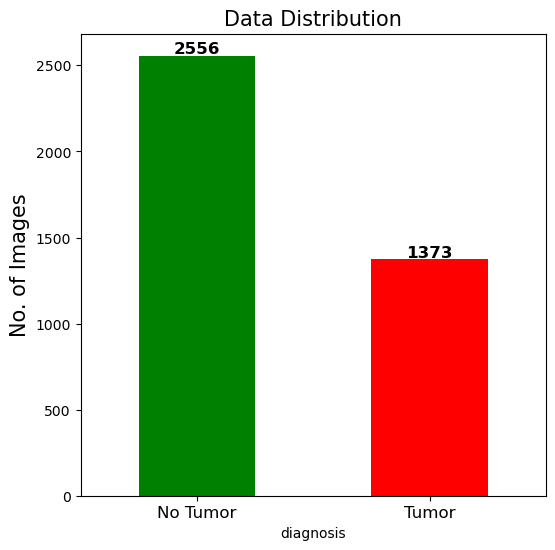

In [5]:
ax = files_df['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(6,6), color=['green', 'red'])
ax.set_title('Data Distribution', fontsize=15)
ax.set_ylabel('No. of Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(files_df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=12)

In [6]:
train_df, val_df = train_test_split(files_df, stratify=files_df['diagnosis'], test_size=0.1, random_state=0)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df['diagnosis'], test_size=0.15, random_state=0)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("Train: {}\nVal: {}\nTest: {}".format(train_df.shape, val_df.shape, test_df.shape))

Train: (3005, 3)
Val: (393, 3)
Test: (531, 3)


In [7]:
train_df

,image_path,mask_path,diagnosis
0,archive 2/kaggle_3m/TCGA_HT_A61B_19991127/TCGA...,archive 2/kaggle_3m/TCGA_HT_A61B_19991127/TCGA...,0
1,archive 2/kaggle_3m/TCGA_CS_6669_20020102/TCGA...,archive 2/kaggle_3m/TCGA_CS_6669_20020102/TCGA...,0
2,archive 2/kaggle_3m/TCGA_CS_6666_20011109/TCGA...,archive 2/kaggle_3m/TCGA_CS_6666_20011109/TCGA...,1
3,archive 2/kaggle_3m/TCGA_FG_6689_20020326/TCGA...,archive 2/kaggle_3m/TCGA_FG_6689_20020326/TCGA...,0
4,archive 2/kaggle_3m/TCGA_DU_6400_19830518/TCGA...,archive 2/kaggle_3m/TCGA_DU_6400_19830518/TCGA...,0
...,...,...,...
3000,archive 2/kaggle_3m/TCGA_FG_A60K_20040224/TCGA...,archive 2/kaggle_3m/TCGA_FG_A60K_20040224/TCGA...,0
3001,archive 2/kaggle_3m/TCGA_DU_7010_19860307/TCGA...,archive 2/kaggle_3m/TCGA_DU_7010_19860307/TCGA...,0
3002,archive 2/kaggle_3m/TCGA_HT_A61A_20000127/TCGA...,archive 2/kaggle_3m/TCGA_HT_A61A_20000127/TCGA...,1
3003,archive 2/kaggle_3m/TCGA_HT_7882_19970125/TCGA...,archive 2/kaggle_3m/TCGA_HT_7882_19970125/TCGA...,0


(-0.5, 1279.5, 255.5, -0.5)

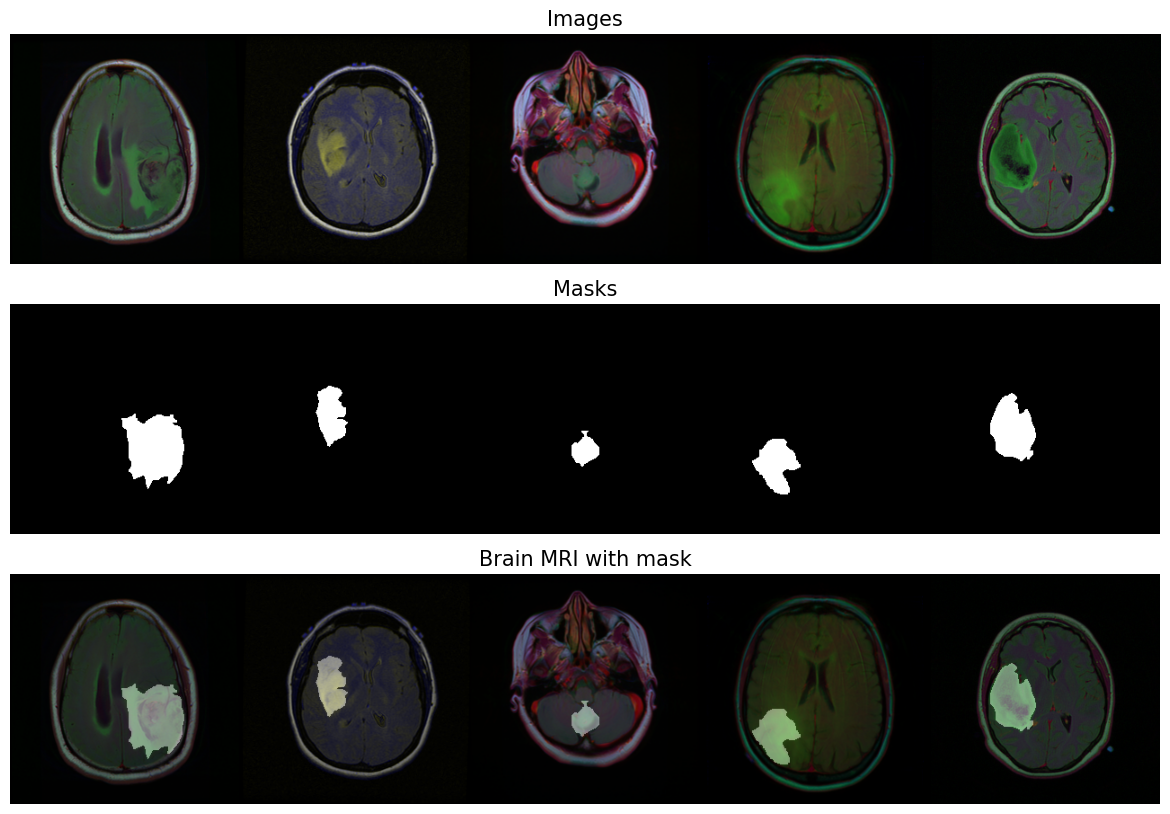

In [8]:
images, masks = [], []
df_positive = train_df[train_df['diagnosis']==1].sample(5).values

for sample in df_positive:
    img = cv2.imread(sample[0])
    mask = cv2.imread(sample[1])
    images.append(img)
    masks.append(mask)
images = np.hstack(np.array(images))
masks = np.hstack(np.array(masks))

fig = plt.figure(figsize=(15,10))
grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=0.4)

grid[0].imshow(images)
grid[0].set_title('Images', fontsize=15)
grid[0].axis('off')
grid[1].imshow(masks)
grid[1].set_title('Masks', fontsize=15)
grid[1].axis('off')
grid[2].imshow(images)
grid[2].imshow(masks, alpha=0.4)
grid[2].set_title('Brain MRI with mask', fontsize=15)
grid[2].axis('off')

In [38]:
class BrainDataset(data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0])
        image = np.array(image)/255.
        mask = cv2.imread(self.df.iloc[idx, 1], 0)
        mask = np.array(mask)/255.
        
        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']
        
        image = image.transpose((2,0,1))
        image = torch.from_numpy(image).type(torch.float32)
        # image = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
        mask = np.expand_dims(mask, axis=-1).transpose((2,0,1))
        mask = torch.from_numpy(mask).type(torch.float32)
        
        return image, mask

In [39]:
train_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
])

val_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
])

test_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0)
])

In [40]:
train_ds = BrainDataset(train_df, train_transform)
val_ds = BrainDataset(val_df, val_transform)
test_ds = BrainDataset(test_df, test_transform)

In [41]:
def dataset_info(dataset): 
    print(f'Size of dataset: {len(dataset)}')
    index = random.randint(1, 40)
    img, label = dataset[index]
    print(f'Sample-{index} Image size: {img.shape}, Mask: {label.shape}\n')

In [42]:
print('Train dataset:')
dataset_info(train_ds)
print('Validation dataset:')
dataset_info(val_ds)
print('Test dataset:')
dataset_info(test_ds)

Train dataset:
Size of dataset: 3005
Sample-37 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])

Validation dataset:
Size of dataset: 393
Sample-3 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])

Test dataset:
Size of dataset: 531
Sample-32 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])



In [43]:
batch_size = 64

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True)  

val_dl = DataLoader(val_ds, 
                    batch_size)

test_dl = DataLoader(val_ds, 
                    batch_size)

In [44]:
images, masks = next(iter(train_dl))
print(images.shape)
print(masks.shape)

torch.Size([64, 3, 128, 128])
torch.Size([64, 1, 128, 128])


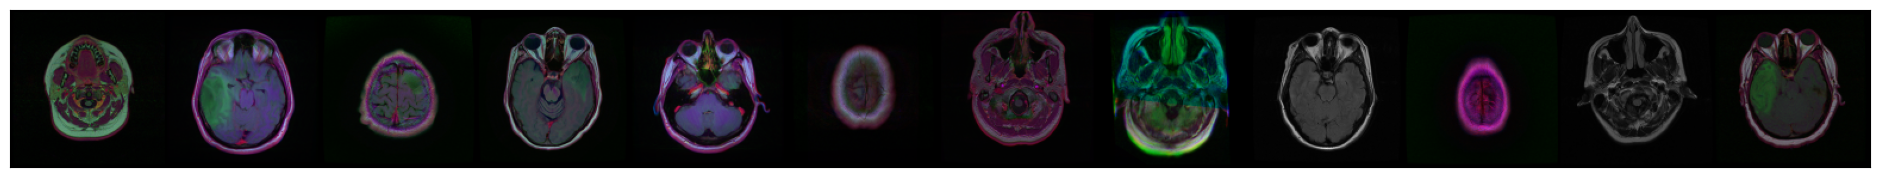

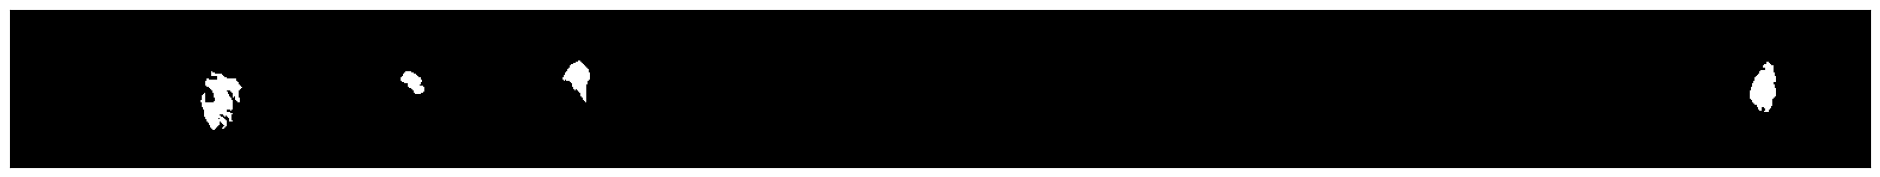

In [51]:
def show_batch(dl):
    for images, masks in dl:

        fig3, ax3 = plt.subplots(figsize=(24, 24))
        ax3.set_xticks([]); ax3.set_yticks([])
        # denorm_images = denormalize(images)
        denorm_images = images 
        ax3.imshow(make_grid(denorm_images[:12], nrow=12).permute(1, 2, 0).clamp(0,1))
        
        fig2, ax2 = plt.subplots(figsize=(24, 24))
        ax2.set_xticks([]); ax2.set_yticks([])
        ax2.imshow(make_grid(masks[:12], nrow=12).permute(1, 2, 0).clamp(0,1))
        break
        
show_batch(val_dl)

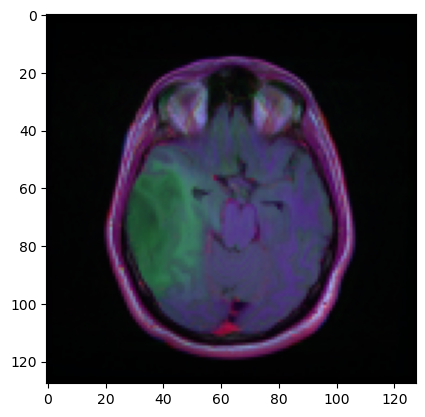

In [163]:
img = np.array(val_ds[1][0]).transpose(1,2,0)
plt.imshow(img)

In [164]:
img.shape 

(128, 128, 3)

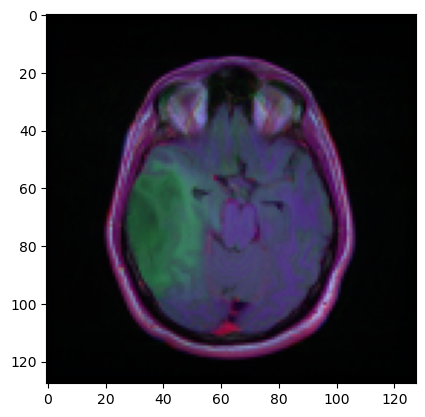

In [165]:
r = 10 
fourier_transform = torch.fft.fft2(torch.tensor(img))
inverse = torch.fft.ifft2(fourier_transform)
real_inverse_f = torch.real(inverse)
plt.imshow(np.array(real_inverse_f)) 

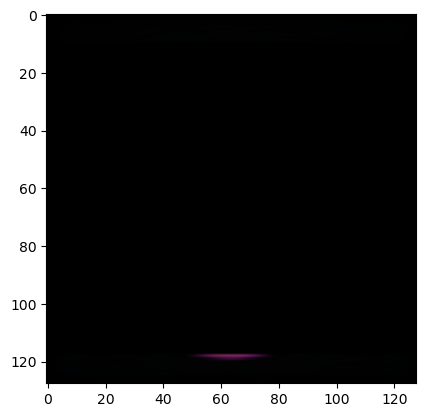

In [162]:
r = 10 
fourier_transform = torch.fft.fft2(torch.tensor(img))
f_compress = torch.complex(torch.zeros(fourier_transform.size()), torch.zeros(fourier_transform.size()))
f_compress[:r, :r, :] = fourier_transform[:r, :r, :]
f_compress[128-r:128, :r, :] = fourier_transform[128-r:128, :r, :]
f_compress[:r, 128-r:128, :] = fourier_transform[:r, 128-r:128, :]
f_compress[128-r:128, 128-r:128, :] = fourier_transform[128-r:128, 128-r:128, :]
# plt.imshow(torch.abs(f_compress))

inverse = torch.fft.ifft2(fourier_transform)
inverse = torch.fft.ifft2(f_compress)
real_inverse_f = torch.real(inverse)
plt.imshow(np.array(real_inverse_f)) 


In [125]:
torch.abs(fourier_transform).shape 

torch.Size([128, 128, 3])

In [ ]:
def low_pass_filter(image, r = 8):
    f = torch.fft.fft2(torch.tensor(image))
    f_compress = torch.complex(torch.zeros(f.size()), torch.zeros(f.size()))
    f_compress[:r, :r] = f[:r, :r]
    f_compress[-r:, :r] = f[-r:, :r]
    f_compress[:r, -r:] = f[:r, -r:]
    f_compress[-r:, -r:] = f[-r:, -r:]

    inverse_f = torch.fft.ifft2(f_compress, norm = "backward")
    real_inverse_f = torch.real(inverse_f)

    return f, f_compress, real_inverse_f

In [134]:
img = np.array(val_ds[1][0]).transpose(1,2,0)

In [140]:
img[:, :, 2].shape 

(128, 128)

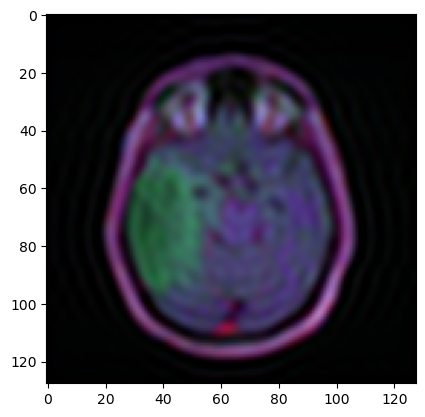

In [157]:
idx = 1
img = np.array(val_ds[idx][0]).transpose(1,2,0)

chanel_1 = img[:, :, 0]
chanel_2 = img[:, :, 1]
chanel_3 = img[:, :, 2]

def low_pass_filter(image, r = 20):
    f = torch.fft.fft2(torch.tensor(image))
    f_compress = torch.complex(torch.zeros(f.size()), torch.zeros(f.size()))
    f_compress[:r, :r] = f[:r, :r]
    f_compress[-r:, :r] = f[-r:, :r]
    f_compress[:r, -r:] = f[:r, -r:]
    f_compress[-r:, -r:] = f[-r:, -r:]

    inverse_f = torch.fft.ifft2(f_compress, norm = "backward")
    real_inverse_f = torch.real(inverse_f)

    return f, f_compress, real_inverse_f

f1, f_compress1, real_inverse_f1 = low_pass_filter(chanel_1)
f2, f_compress2, real_inverse_f2 = low_pass_filter(chanel_2)
f3, f_compress3, real_inverse_f3 = low_pass_filter(chanel_3)



plt.imshow(np.stack([real_inverse_f1, real_inverse_f2, real_inverse_f3], axis=-1))